# File Description
The purpose of this notebook is to do an intial analysis of the data provided by Antonio (emailed on 23/12/2020).
The data are simulations of inundation drivers and the resulting total water level (TWL) for the Tarawa Atoll.
There are two datasets: Pto_110, which is lagoon side, and Pto_218, which is ocean side.

In this file, I:
- Read and format the data.
- Plot basic histograms and visualisations of the data.

Key:
- All blue points/lines are the lagoon side
- All red points/lines are ocean side
    
    

## Information Copied from Antonio's email

%% waves at the green point used to determine wave fluxing (wave setup) inside the lagoon
data.Hs_offshore% Significant wave height (m)
data.Tm_offshore% Mean wave period (s)
data.Dir_offshore% Mean wave direction (degrees, 0 waves coming from the North, 90 from the East)
 
%% wind at the red point, to resolve wind setup inside the lagoon
data.Wind% wind speed (m/s)
data.WindDir% wind direction (degrees, 0 waves coming from the North, 90 from the East)
 
%% offshore water levels
data.Tide% astronomica tide (m)
data.MSL% sea level anomaly (m)
 
%% waves at the toe of the profile to estimate wave run up
data.Hs_point_110% Significant wave height (m)
 
%% total water level in the blue point (point 110)
data.TWL_point_110% TWL (m)

For the point on the ocean side (Point 218)
 
data.Time
data.Tide
data.MSL
 
%% waves at the toe of the reef profile to estimate wave run up, here we use more parameters due to the larger contribution of the waves on the ocean side
data.Hs_point_218
data.Tm_point_218
 
data.TWL_point_218

![title](map_tarawa_antonio.jpeg)

# File setup

## Import Modules

In [1]:
# Install required packages
import numpy as np
import cartopy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import gridspec
import pysmile
import pysmile_license
import rpy2
import graphviz 
import xml.etree.ElementTree
import itertools
from sklearn.preprocessing import KBinsDiscretizer
import os
import math
import xarray as xr
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
os.environ['R_HOME'] = '/lib/R'
%load_ext rpy2.ipython

In [7]:
%%sh

pip3 install cite2c
cite2c.install

  Created wheel for rauth: filename=rauth-0.7.3-py3-none-any.whl size=16057 sha256=b701c9d6f41ae5ece44675f4db59a02d5782441ff6dc9acfccaaf95c41f2eb06
  Stored in directory: /root/.cache/pip/wheels/12/ba/46/fba7d3f89b3f871b076908875f0b61fa6fba64af01c7b53036
Successfully built rauth


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
sh: 3: cite2c.install: not found


CalledProcessError: Command 'b'\npip3 install cite2c\ncite2c.install\n'' returned non-zero exit status 127.

## Create Functions and Classes

In [2]:
class BN_visualisation():
    
    #graph = graphviz.Digraph(format='svg',comment='ext', engine="dot")
    
    def __init__(self,ds,df,net):
        
        self.graph = self.create_graph()
        
        self.node_id_dict = self.create_node_id_dict(ds,df)
        
#         self.graph = self.create_nodes(ds,df);
        
        self.graph = self.create_arcs(net,ds,df)
            
    def create_graph(self):
        '''
            Function that is just to set up the graph
                kwargs:
                    - None
                returns:
                    - The graph with nothing in it
        '''
        # Create graph using graphviz
        graph = graphviz.Digraph(format='svg',comment='ext', engine="dot")
        
        # Return graph
        return(graph)
    
    def create_node_id_dict(self,ds,df):
        '''
            Function that gets the nodes and node ids and returns them
                kwargs:
                    - ds: A pysmile.learning.DataSet
                    - df: A pandas.DataFrame, which must have the same variables in the same order as the ds
                returns:
                    - The graph object with the nodes added (in no particular spot)               
        '''
        
        # Get the name of the variables (node_names)
        node_names = list(df)
        
        # Get column name dataset indicies (node_ids)
        node_ids = [ds.find_variable(x) for x in node_names]
        
        # Create an empty dictionary to add 
        node_id_to_name_dict = {}
        
        # Loop over each node (name and ID) and add to dict
        for node_id,node_name in zip(node_ids,node_names):
            node_id_to_name_dict.update({
                node_id:node_name
            })
            
        # Return the dict of node ids and node names
        return(node_id_to_name_dict)

#     def create_nodes(self,ds,df):
#         '''
#             Function that adds nodes from a dataset and a dataframe to an existing graph
#                 kwargs:
#                     - ds: A pysmile.learning.DataSet
#                     - df: A pandas.DataFrame, which must have the same variables in the same order as the ds
#                 returns:
#                     - The graph object with the nodes added (in no particular spot)        
#         '''
        
#         # Loop over each node (name and ID) and add node to graph
#         for node_id,node_name in self.node_id_dict.items():
#             self.graph.node(str(node_id),node_name)
            
#         # Return the graph with the nodes created
#         return(self.graph)
    
    def create_arcs(self,net,ds,df):
        '''
            Function that create arcs and adds them to the existing graph using the dataset and dataframe
            kwargs:
                - net: A pysmile.Network
                - ds: A pysmile.learning.DataSet. Must correspond to network.
                - df: A pandas.DataFrame, which must have the same variables in the same order as the ds
            returns:
                - The graph object with arcs added.
        '''
    
        # Loop over each node
        for node_id in self.node_id_dict.keys():
            # Continue if a node actually has child arcs
            if net.get_children(node_id)!=[]:
                # Loop over each child of the node
                for child in net.get_children(node_id):
                    # Add edges to the graph
                    self.graph.edge(self.node_id_dict[node_id],self.node_id_dict[child])

        # Return the graph with edges
        return(self.graph)
    

## Read and format data

In [3]:
# Download the data 
df_Pto_lagoon = pd.read_csv(r'C:\Users\shannonb\Documents\Model_and_data\Dataset\D2_SPC_inundation_model\Pto_110_lagoonside.csv') # Lagoon side data
df_Pto_ocean = pd.read_csv(r'C:\Users\shannonb\Documents\Model_and_data\Dataset\D2_SPC_inundation_model\Pto_218_oceanside.csv') # ocean side data

In [4]:
%%R -i df_Pto_lagoon -i df_Pto_ocean

# Summarise the data
print("Summarise the data")
print("Lagoon Summary")
print(summary(df_Pto_lagoon))
print('')
print("Ocean Summary")
print(summary(df_Pto_ocean))


[1] "Summarise the data"
[1] "Lagoon Summary"
     Time            Hs_offshore      Tm_offshore      Dir_offshore     
 Length:227904      Min.   :0.2782   Min.   : 1.599   Min.   :  0.0046  
 Class :character   1st Qu.:0.7512   1st Qu.: 2.572   1st Qu.:117.1150  
 Mode  :character   Median :0.9228   Median : 2.867   Median :162.1920  
                    Mean   :0.9550   Mean   : 3.310   Mean   :167.3276  
                    3rd Qu.:1.1163   3rd Qu.: 3.417   3rd Qu.:206.1904  
                    Max.   :3.2590   Max.   :12.383   Max.   :359.9993  
      Wind              WindDir            Tide                 MSL            
 Min.   : 0.005711   Min.   :-89.99   Min.   :-1.1266828   Min.   :-0.2273523  
 1st Qu.: 3.543112   1st Qu.:153.80   1st Qu.:-0.3711844   1st Qu.:-0.0380296  
 Median : 5.021496   Median :178.37   Median :-0.0078022   Median :-0.0009181  
 Mean   : 4.939954   Mean   :161.21   Mean   :-0.0000016   Mean   :-0.0005191  
 3rd Qu.: 6.372063   3rd Qu.:197.85   3rd Q

In [5]:
# Print the variables for the ocean side
print('Ocean side file variables',list(df_Pto_ocean))

Ocean side file variables ['Time', 'Tide', 'MSL', 'Hs_point_218', 'Tm_point_218', 'TWL_point_218']


In [6]:
# Print the variables for the lagoon side
print('Lagoon side file variables',list(df_Pto_lagoon))

Lagoon side file variables ['Time', 'Hs_offshore', 'Tm_offshore', 'Dir_offshore', 'Wind', 'WindDir', 'Tide', 'MSL', 'Hs_point_110', 'TWL_point_110']


In [7]:
# Convert the date time to a proper datetime format
df_Pto_lagoon['Time'] = [datetime.strptime(x,'%m/%d/%y %H:%M:%S') for x in df_Pto_lagoon['Time']]
df_Pto_ocean['Time'] = [datetime.strptime(x,'%m/%d/%y %H:%M:%S') for x in df_Pto_ocean['Time']]

# # Convert datetime to to number of days and hours count
# df_Pto_lagoon['Time'] = df_Pto_lagoon['Time']-np.min(df_Pto_lagoon['Time'])
# df_Pto_ocean['Time'] = df_Pto_ocean['Time']-np.min(df_Pto_ocean['Time'])

In [8]:
# Remove the tide from the total water level in both files
# (since there is a very obvious relationship between them)
df_Pto_lagoon['TWL_point_110_less_Tide'] = df_Pto_lagoon['Tide']-df_Pto_lagoon['TWL_point_110']
df_Pto_ocean['TWL_point_218_less_Tide'] = df_Pto_ocean['Tide']-df_Pto_ocean['TWL_point_218']

In [9]:
# Make a lists of the independent vars (excluding time)
ind_vars_lagoon = [x for x in list(df_Pto_lagoon) if x not in ['Time','TWL_point_110','TWL_point_110_less_Tide']]
ind_vars_ocean = [x for x in list(df_Pto_ocean) if x not in ['Time','TWL_point_218','TWL_point_218_less_Tide']]

# Make a lists of the all vars (excluding time)
all_vars_lagoon = [x for x in list(df_Pto_lagoon) if x not in ['Time']]
all_vars_ocean = [x for x in list(df_Pto_ocean) if x not in ['Time']]

# Data Histograms

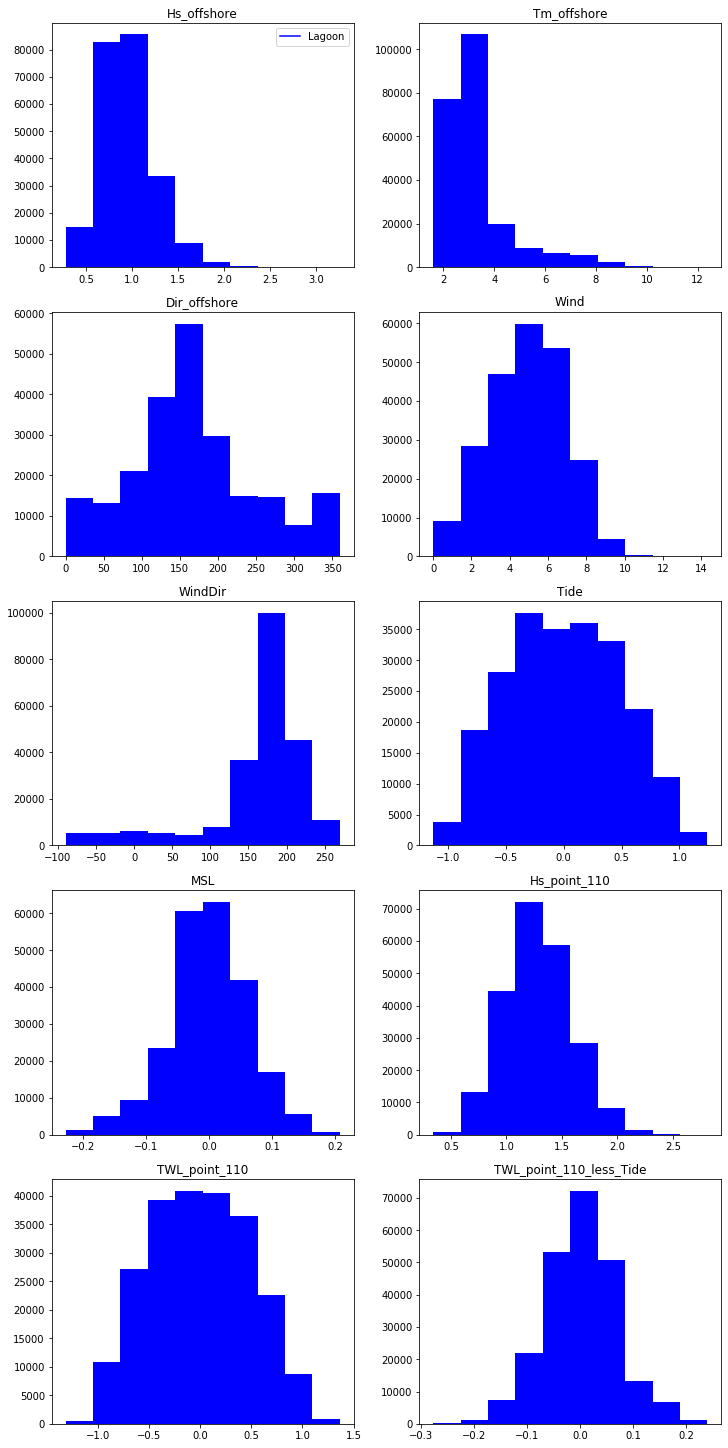

In [10]:
# Set up the figure
fig = plt.figure(constrained_layout=True,figsize=(10,20))
spec = gridspec.GridSpec(ncols=2, nrows=5, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[2, 0])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[3, 0])
ax8 = fig.add_subplot(spec[3, 1])
ax9 = fig.add_subplot(spec[4, 0])
ax10 = fig.add_subplot(spec[4, 1])

# Loop over each of the variables for the lagoon side and make histograms
for ax,col_lagoon in zip([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],all_vars_lagoon):
    ax.hist(df_Pto_lagoon[col_lagoon],color='b')
    
    # Format the axes
    ax.set_title(col_lagoon)
    
# Create legend
lagoon_leg, = plt.plot([],[],c='b',label='Lagoon')
ax1.legend(handles=[lagoon_leg])

print('')

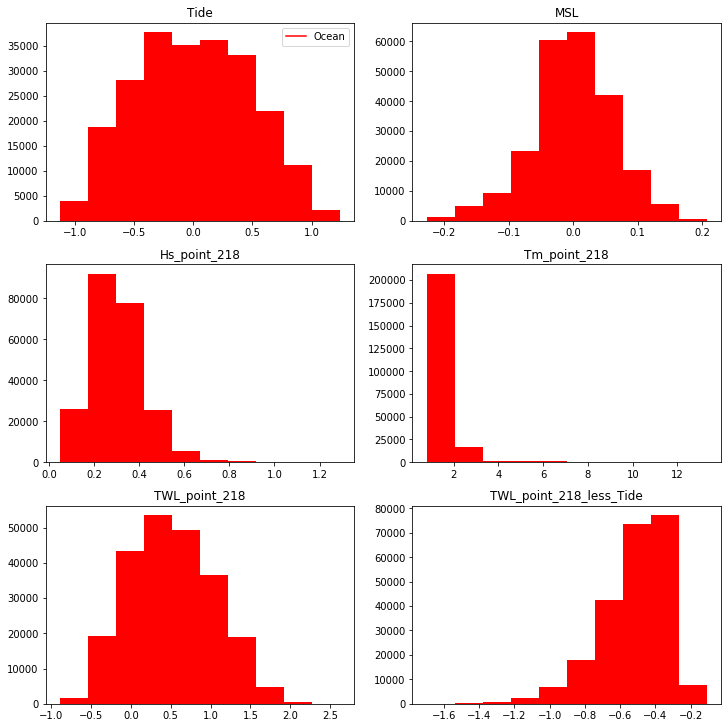

In [11]:
# Set up the figure
fig = plt.figure(constrained_layout=True,figsize=(10,10))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[2, 0])
ax6 = fig.add_subplot(spec[2, 1])

# Loop over each of the variables for the ocean side and make histograms
for ax,col_ocean in zip([ax1,ax2,ax3,ax4,ax5,ax6],all_vars_ocean):
    ax.hist(df_Pto_ocean[col_ocean],color='r')

    # Format the axes
    ax.set_title(col_ocean)
    
# Create legend
ocean_leg, = plt.plot([],[],c='r',label='Ocean')
ax1.legend(handles=[ocean_leg])

print('')

# Variable scatter plots with total water level

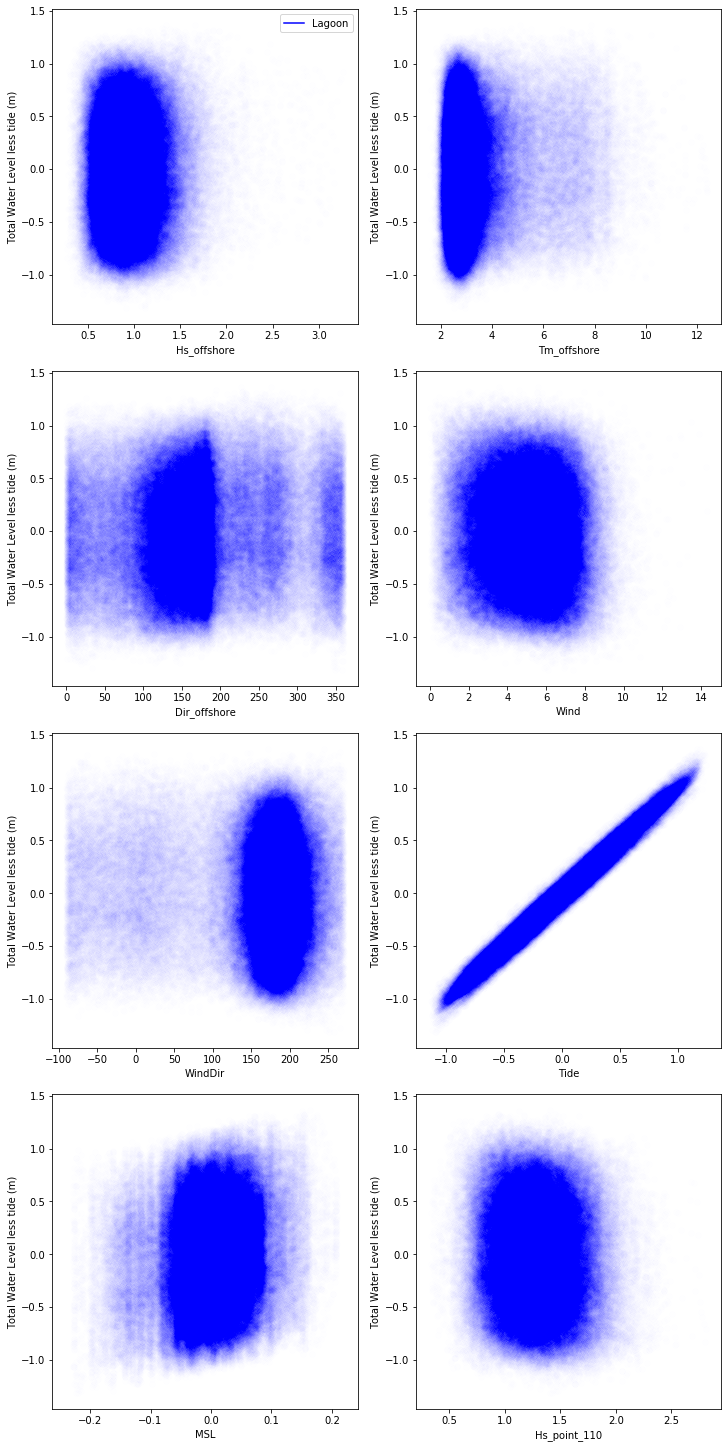

In [12]:
# Set up the figure
fig = plt.figure(constrained_layout=True,figsize=(10,20))
spec = gridspec.GridSpec(ncols=2, nrows=4, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[2, 0])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[3, 0])
ax8 = fig.add_subplot(spec[3, 1])

# Loop over the variables, and plot var vs total water level for the lagoon side
for ax,col_lagoon in zip([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8],ind_vars_lagoon):
    ax.scatter(df_Pto_lagoon[col_lagoon],df_Pto_lagoon['TWL_point_110'],alpha=0.005,c='b')
    ax.set_xlabel(col_lagoon)
    ax.set_ylabel('Total Water Level less tide (m)')
    
# Create legend
lagoon_leg, = plt.plot([],[],c='b',label='Lagoon')
ax1.legend(handles=[lagoon_leg])

print('')

# Looking at seasonal variability

### Wind Direction

In [13]:
# 
df_Pto_lagoon['month'] = [x.month for x in df_Pto_lagoon.Time]
df_Pto_ocean['month'] = [x.month for x in df_Pto_ocean.Time]

df_lagoon_sample = df_Pto_lagoon

df_lagoon_sample['WindDir'] = round(df_lagoon_sample.WindDir/5,0)*5

lagoon_grouped_dict = {}

for key,group in df_lagoon_sample.groupby(['WindDir','month']):
    
    group_mean = np.mean(group)
    group_mean['WindCount'] = len(group)
    
    lagoon_grouped_dict.update({
        key:group_mean
    })

df_lagoon_sample = pd.DataFrame.from_dict(lagoon_grouped_dict,orient='index')
df_lagoon_sample.reset_index(drop=True,inplace=True)

C:\Users\shannonb\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3417: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


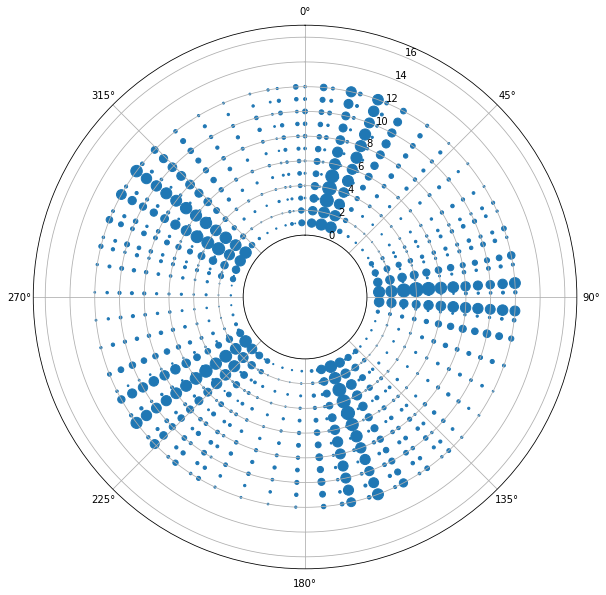

In [14]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='polar')

c = ax.scatter(df_lagoon_sample.WindDir,df_lagoon_sample.month, s=df_lagoon_sample.WindCount/10, cmap='hsv', alpha=1)

ax.set_rorigin(-5)
ax.set_theta_zero_location('W', offset=-90)
ax.set_theta_direction(-1)

plt.show()

### Wave direction

In [15]:

df_lagoon_sample = df_Pto_lagoon

df_lagoon_sample['Dir_offshore'] = round(df_lagoon_sample.Dir_offshore/5,0)*5

lagoon_grouped_dict = {}

for key,group in df_lagoon_sample.groupby(['Dir_offshore','month']):
    
    group_mean = np.mean(group)
    group_mean['Dir_offshore_count'] = len(group)
    
    lagoon_grouped_dict.update({
        key:group_mean
    })

df_lagoon_sample = pd.DataFrame.from_dict(lagoon_grouped_dict,orient='index')
df_lagoon_sample.reset_index(drop=True,inplace=True)

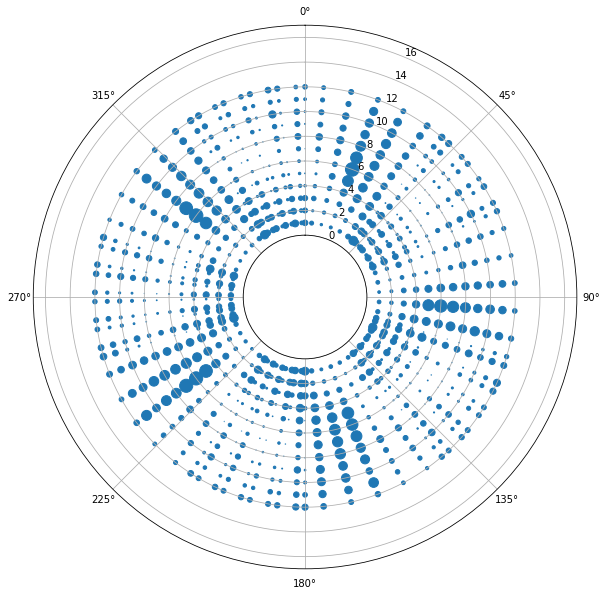

In [16]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='polar')

c = ax.scatter(df_lagoon_sample.Dir_offshore,df_lagoon_sample.month, s=df_lagoon_sample.Dir_offshore_count/10, cmap='hsv', alpha=1)

ax.set_rorigin(-5)
ax.set_theta_zero_location('W', offset=-90)
ax.set_theta_direction(-1)

plt.show()

# Wave height

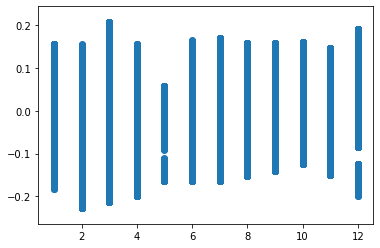

In [17]:



plt.scatter(df_Pto_lagoon.month,df_Pto_ocean.MSL)

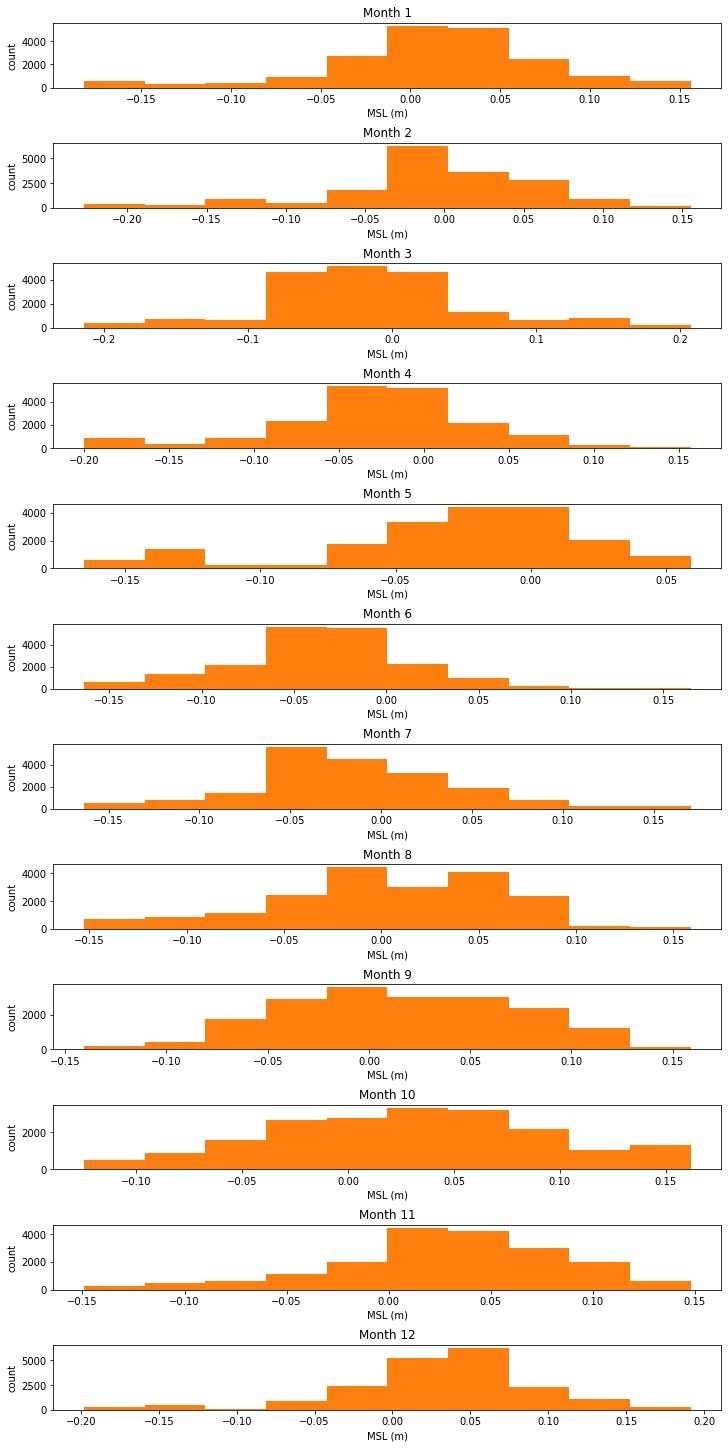

In [18]:
# Set up the figure
fig = plt.figure(constrained_layout=True,figsize=(10,20))
gs = gridspec.GridSpec(ncols=1, nrows=12, figure=fig)

for month in np.arange(1,13):
    ax = fig.add_subplot(gs[month-1])
    
    df_Pto_lagoon_month_x = df_Pto_lagoon[df_Pto_lagoon['month']==(month)]
    df_Pto_ocean_month_x = df_Pto_ocean[df_Pto_ocean['month']==(month)]
    
    ax.hist(df_Pto_lagoon_month_x.MSL)
    ax.hist(df_Pto_ocean_month_x.MSL)
    
    ax.set_ylabel('count')
    ax.set_xlabel('MSL (m)')
    ax.set_title('Month {}'.format(month))
    

NB: the MSL is unaffected by the wind and waves, and is the same between the two datasets
The tide is also the same between the two datasets

In [19]:
df_Pto_lagoon['year'] = [x.year for x in df_Pto_lagoon.Time]
df_Pto_ocean['year'] = [x.year for x in df_Pto_ocean.Time]

In [20]:
df_Pto_lagoon_year_month_grouping = df_Pto_lagoon.groupby(['month','year']).mean().reset_index()
df_Pto_ocean_year_month_grouping = df_Pto_ocean.groupby(['month','year']).mean().reset_index()

first_year_ocean = np.min(df_Pto_ocean_year_month_grouping['year'])
first_year_lagoon = np.min(df_Pto_lagoon_year_month_grouping['year'])

df_Pto_ocean_year_month_grouping['month_count'] = \
    df_Pto_ocean_year_month_grouping['month']+12*(df_Pto_ocean_year_month_grouping.year-first_year_ocean)

df_Pto_lagoon_year_month_grouping['month_count'] = \
    df_Pto_lagoon_year_month_grouping['month']+12*(df_Pto_lagoon_year_month_grouping.year-first_year_lagoon)

df_Pto_lagoon_year_month_grouping.sort_values(['month_count'],inplace=True)
df_Pto_ocean_year_month_grouping.sort_values(['month_count'],inplace=True)


In [21]:
df_ENSO = pd.read_csv(r'C:\Users\shannonb\Documents\Model_and_data\Dataset\D5_ENSO\meiv2_edited.data', delim_whitespace=True)
df_ENSO = df_ENSO.set_index('Year')
df_ENSO = pd.DataFrame(df_ENSO.stack(),columns=['MEI'])
df_ENSO.reset_index(inplace=True)
df_ENSO.rename(columns={'level_1':'month'},inplace=True)
months_dict = {'DJ':1,'JF':2,'FM':3,'MA':4,'AM':5,'MJ':6,'JJ':7,'JA':8,'AS':9,'SO':10,'ON':11,'ND':12}
df_ENSO['month'] = [months_dict[month] for month in df_ENSO.month]
df_ENSO['Year_diff'] = df_ENSO.Year-first_year_lagoon
df_ENSO = df_ENSO[df_ENSO['Year_diff']>=0]
df_ENSO['month_count'] = df_ENSO.Year_diff*12+df_ENSO.month
df_ENSO = df_ENSO[df_ENSO['MEI']!=-999]

In [22]:
### MEI is v negative for la niña and v positive for el niño

df_la_nina = df_ENSO[(df_ENSO.MEI>=0.5)]
df_el_nino = df_ENSO[(df_ENSO.MEI<=-0.5)]

In [23]:
df_la_nina.month_count

168      1
169      2
170      3
171      4
172      5
      ... 
447    280
448    281
476    309
481    314
482    315
Name: month_count, Length: 74, dtype: int64

In [24]:
df_la_nina['is_cont'] = df_la_nina.month_count-(list(df_la_nina.month_count[1:])+[0])

df_la_nina_grouped = {0:[]}
group_count = 0

for index,row in df_la_nina.iterrows():
    if row.is_cont==-1:
        df_la_nina_grouped.update({
            group_count:df_la_nina_grouped[group_count]+[row['month_count']]
        })
    else:
        group_count+=1
        df_la_nina_grouped.update({
            group_count:[]
        })

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
df_el_nino['is_cont'] = df_el_nino.month_count-(list(df_el_nino.month_count[1:])+[0])

df_el_nino_grouped = {0:[]}
group_count = 0

for index,row in df_el_nino.iterrows():
    if row.is_cont==-1:
        df_el_nino_grouped.update({
            group_count:df_el_nino_grouped[group_count]+[row['month_count']]
        })
    else:
        group_count+=1
        df_el_nino_grouped.update({
            group_count:[]
        })

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
x=0

year_index = {}

lagoon_year = first_year_lagoon

while x<np.max(df_Pto_lagoon_year_month_grouping['month_count']):
    year_index.update({
        x:lagoon_year
    })
    x+=12
    lagoon_year+=1

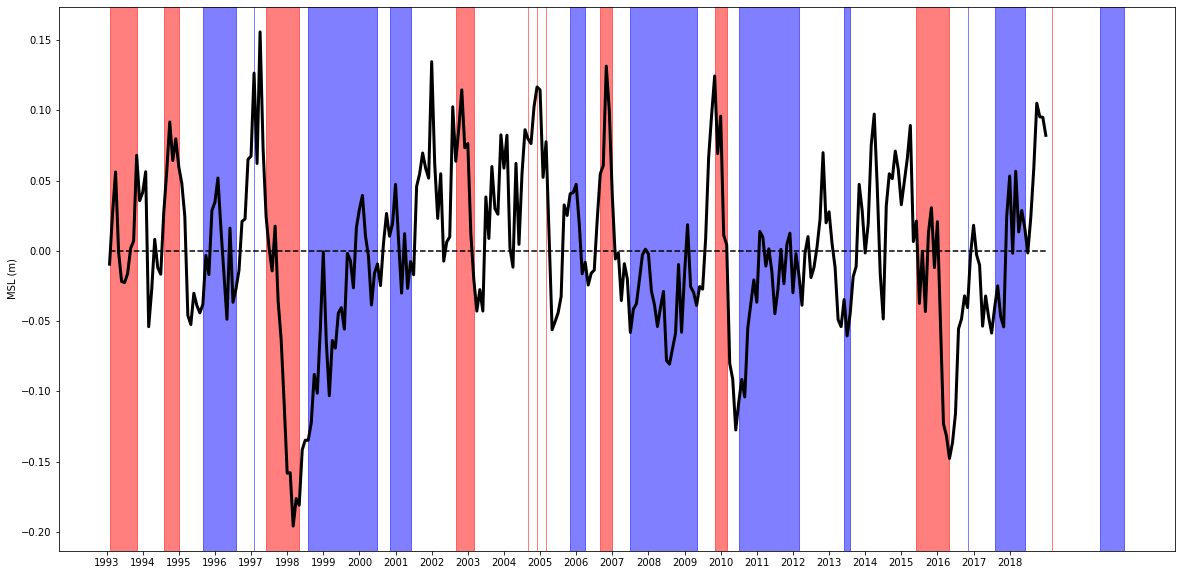

In [27]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot2grid((1,1),(0,0))

for group,index_list in df_la_nina_grouped.items():
    try:
        ax.axvspan(ymin=-1000,ymax=1000,xmin=np.min(index_list),xmax=np.max(index_list),color='r',alpha=0.5,zorder=-1000)
    except:
        pass
    
for group,index_list in df_el_nino_grouped.items():
    try:
        ax.axvspan(ymin=-1000,ymax=1000,xmin=np.min(index_list),xmax=np.max(index_list),color='b',alpha=0.5,zorder=-1000)
    except:
        pass
    
ax.plot(df_Pto_lagoon_year_month_grouping['month_count'],df_Pto_lagoon_year_month_grouping['MSL'],c='k',lw=3)
ax.plot([np.min(df_Pto_lagoon_year_month_grouping['month_count']),np.max(df_Pto_lagoon_year_month_grouping['month_count'])],
      [0,0],c='k',ls='--')

ax.set_ylabel('MSL (m)')
ax.set_ylabel('MSL (m)')

ax.set_xticks(list(year_index.keys()))
ax.set_xticklabels(list(year_index.values()))

plt.show()

In [28]:
df_ENSO.rename(columns={'Year':'year'},inplace=True)
df_ENSO.set_index(['year','month'],inplace=True)
df_Pto_lagoon_year_month_grouping.set_index(['year','month'],inplace=True)


In [29]:
df_Pto_lagoon_year_month_grouping_ENSO = pd.merge(df_Pto_lagoon_year_month_grouping,df_ENSO)


Call:
lm(formula = MSL ~ MEI, data = df_Pto_lagoon_year_month_grouping_ENSO)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.206518 -0.032914  0.000634  0.039052  0.156996 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -9.090e-06  3.371e-03  -0.003    0.998
MEI          4.408e-03  3.488e-03   1.264    0.207

Residual standard error: 0.05896 on 310 degrees of freedom
Multiple R-squared:  0.005126,	Adjusted R-squared:  0.001917 
F-statistic: 1.597 on 1 and 310 DF,  p-value: 0.2072



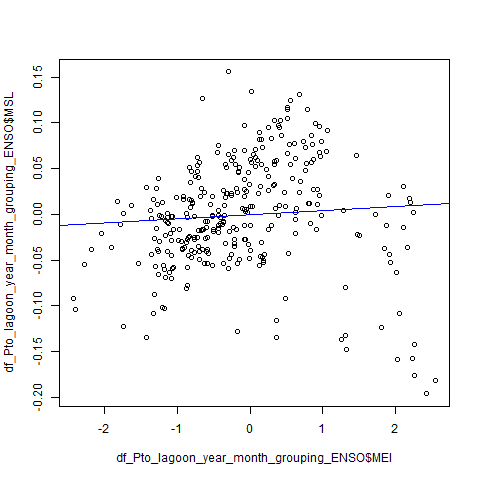

In [30]:
%%R -i df_Pto_lagoon_year_month_grouping_ENSO

library(pracma)

plot(df_Pto_lagoon_year_month_grouping_ENSO$MEI,df_Pto_lagoon_year_month_grouping_ENSO$MSL)

linreg = lm(MSL ~ MEI, data=df_Pto_lagoon_year_month_grouping_ENSO)

abline(linreg,col='blue')

mei_mavg = movavg(df_Pto_lagoon_year_month_grouping_ENSO$MEI,30)

# points(mei_mavg,df_Pto_lagoon_year_month_grouping_ENSO$MSL,col='red')

summary(linreg)

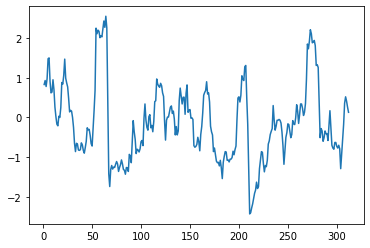

In [31]:
plt.plot(df_Pto_lagoon_year_month_grouping_ENSO['month_count'],df_Pto_lagoon_year_month_grouping_ENSO['MEI'])

In [32]:
%%R

library('pracma')

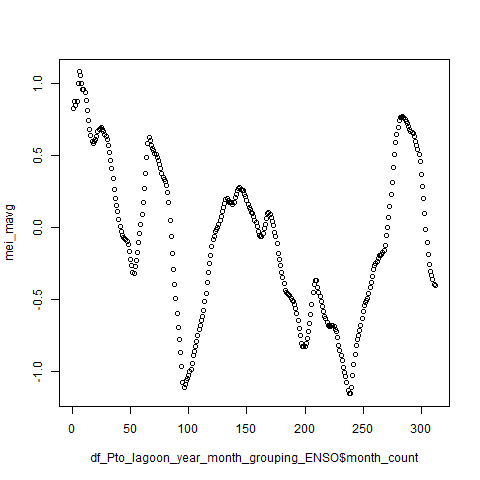

In [33]:
%%R -i df_Pto_lagoon_year_month_grouping_ENSO

mei_mavg = movavg(df_Pto_lagoon_year_month_grouping_ENSO$MEI,30)

plot(df_Pto_lagoon_year_month_grouping_ENSO$month_count,mei_mavg)

# Seeing TWL w.r.t. MSL

Text(0, 0.5, 'Total water level less tide less mean sea-level')

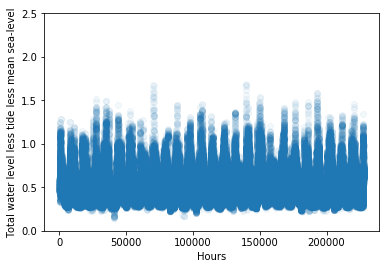

In [63]:
ax1 = plt.subplot2grid((1,1),(0,0))

ax1.scatter(df_Pto_ocean.index,(df_Pto_ocean['TWL_point_218']-df_Pto_ocean['MSL']-df_Pto_ocean['Tide']),alpha=0.05)

ax1.set_ylim([0,2.5])
ax1.set_xlabel('Hours')
ax1.set_ylabel('Total water level less tide less mean sea-level')

Text(0, 0.5, 'Total water level less tide less mean sea-level')

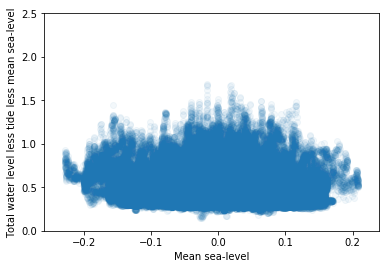

In [64]:
ax1 = plt.subplot2grid((1,1),(0,0))

ax1.scatter(df_Pto_ocean['MSL'],(df_Pto_ocean['TWL_point_218']-df_Pto_ocean['MSL']-df_Pto_ocean['Tide']),alpha=0.05)

ax1.set_ylim([0,2.5])
ax1.set_xlabel('Mean sea-level')
ax1.set_ylabel('Total water level less tide less mean sea-level')

Text(0, 0.5, 'Total water level less tide less mean sea-level')

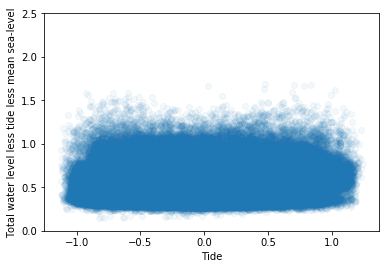

In [66]:
ax1 = plt.subplot2grid((1,1),(0,0))

ax1.scatter(df_Pto_ocean['Tide'],(df_Pto_ocean['TWL_point_218']-df_Pto_ocean['MSL']-df_Pto_ocean['Tide']),alpha=0.05)

ax1.set_ylim([0,2.5])
ax1.set_xlabel('Tide')
ax1.set_ylabel('Total water level less tide less mean sea-level')

Text(0, 0.5, 'Total water level less tide less mean sea-level')

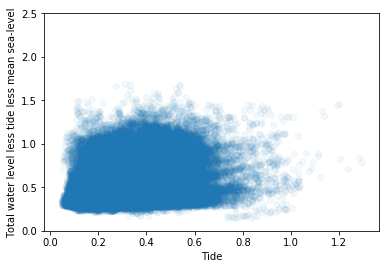

In [68]:
ax1 = plt.subplot2grid((1,1),(0,0))

ax1.scatter(df_Pto_ocean['Hs_point_218'],(df_Pto_ocean['TWL_point_218']-df_Pto_ocean['MSL']-df_Pto_ocean['Tide']),alpha=0.05)

ax1.set_ylim([0,2.5])
ax1.set_xlabel('Tide')
ax1.set_ylabel('Total water level less tide less mean sea-level')

Text(0, 0.5, 'Total water level less tide less mean sea-level')

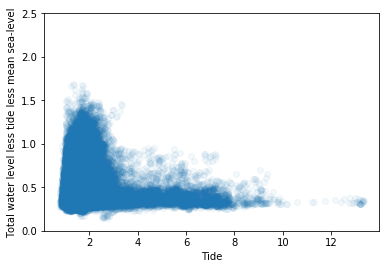

In [69]:
ax1 = plt.subplot2grid((1,1),(0,0))

ax1.scatter(df_Pto_ocean['Tm_point_218'],(df_Pto_ocean['TWL_point_218']-df_Pto_ocean['MSL']-df_Pto_ocean['Tide']),alpha=0.05)

ax1.set_ylim([0,2.5])
ax1.set_xlabel('Tide')
ax1.set_ylabel('Total water level less tide less mean sea-level')

Notes:
 - MSL changes with tide. If you look at MSL vs TWL-less tide, there is an inverse relationship, but with tide it is virtually 1:1

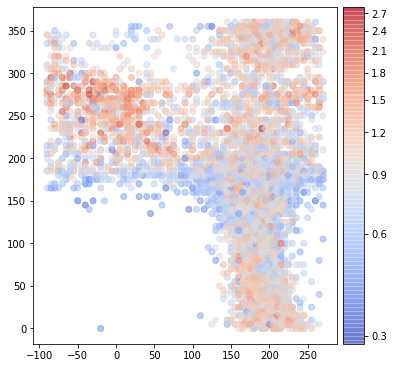

In [34]:
# Set up the figure
fig = plt.figure(constrained_layout=True,figsize=(5,5))
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])

df_Pto_lagoon_sample = df_Pto_lagoon.sample(10000)
                      
# ax1.scatter(df_Pto_lagoon['WindDir'],df_Pto_lagoon['Wind'],alpha=0.005,c='b')
output = ax1.scatter(df_Pto_lagoon_sample['WindDir'],df_Pto_lagoon_sample['Dir_offshore'],
                     c=[math.log(x,10) for x in df_Pto_lagoon_sample['Hs_offshore']],
                     alpha=0.5,cmap='coolwarm')

# Add legend
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb = fig.colorbar(output,cax=cax1,ticks=[math.log(x,10) for x in np.arange(0.3,3.3,0.3)])
cax1.set_yticklabels([round(10**x,1) for x in cax1.get_yticks()])



plt.show()

In [35]:
np.min(df_Pto_lagoon_sample['Hs_offshore'])

math.log(0.3)
math.log(3.3)



1.1939224684724346

In [36]:
np.max(df_Pto_lagoon_sample['Hs_offshore'])

2.82346200942993

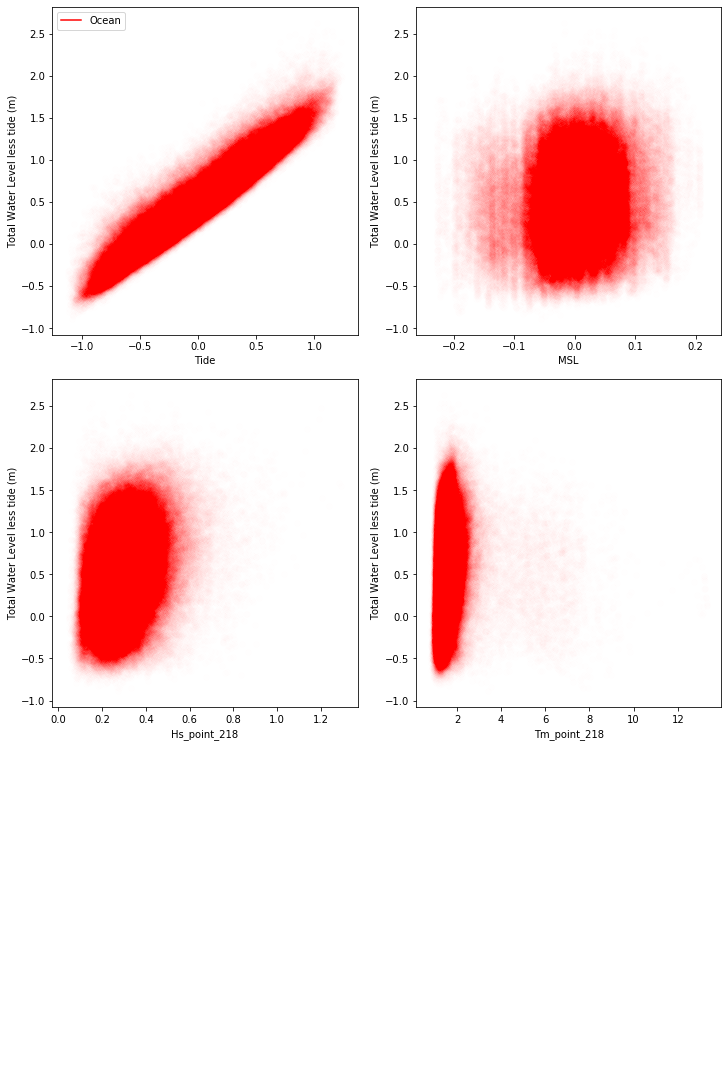

In [37]:
# Set up the figure
fig = plt.figure(constrained_layout=True,figsize=(10,15))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])

# Loop over the variables, and plot var vs total water level for the ocean side
for ax,col_ocean in zip([ax1,ax2,ax3,ax4],ind_vars_ocean):
    ax.scatter(df_Pto_ocean[col_ocean],df_Pto_ocean['TWL_point_218'],alpha=0.005,c='r')
    
    # Format the axes
    ax.set_xlabel(col_ocean)
    ax.set_ylabel('Total Water Level less tide (m)')
    
# Create legend
ocean_leg, = plt.plot([],[],c='r',label='Ocean')
ax1.legend(handles=[ocean_leg])
    
print('')

# Correlation

## Matricies of correlation between variables

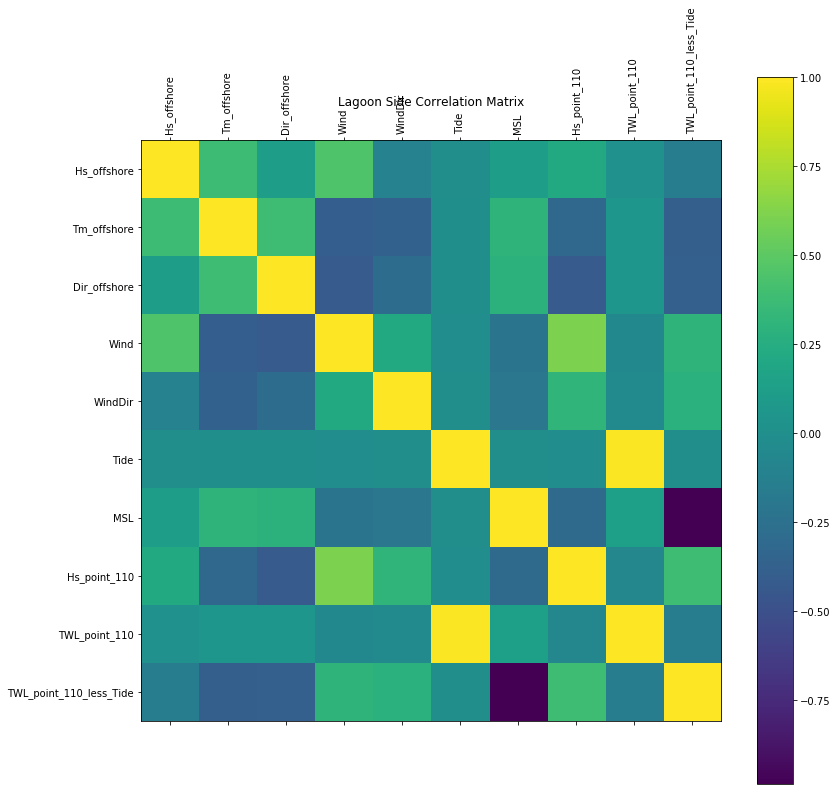

In [38]:

# Setup the figure
fig, ax1 = plt.subplots(figsize=(13,13))

# Plot the correlation matrix of the pandas dataframe of all variables except time
output = ax1.matshow(df_Pto_lagoon[all_vars_lagoon].corr(),cmap='viridis')

# Format axes
ax1.set_xticks(np.arange(0,len(list(df_Pto_lagoon[all_vars_lagoon])),1))
ax1.set_yticks(np.arange(0,len(list(df_Pto_lagoon[all_vars_lagoon])),1))
ax1.set_xticklabels(list(df_Pto_lagoon[all_vars_lagoon]))
ax1.set_yticklabels(list(df_Pto_lagoon[all_vars_lagoon]))
plt.xticks(rotation=90)

# Set figure title
ax1.set_title('Lagoon Side Correlation Matrix')

# Add legend
cb = fig.colorbar(output)

plt.show()

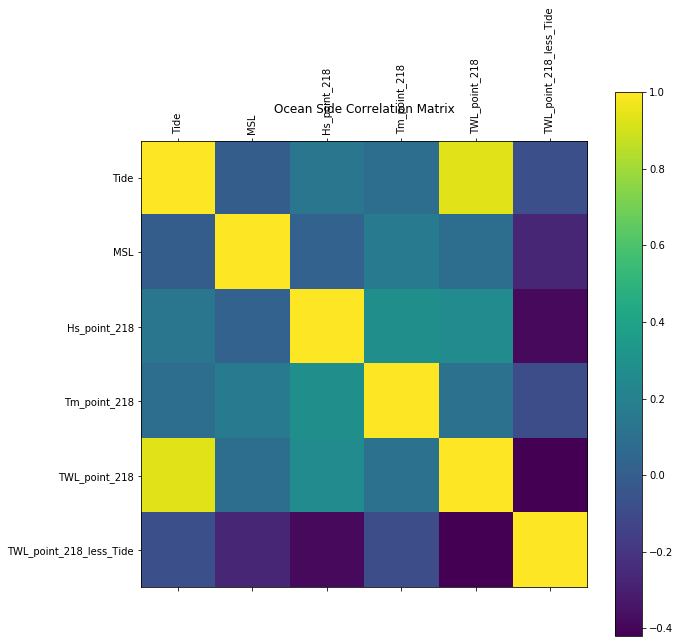

In [39]:

# Setup the figure
fig, ax1 = plt.subplots(figsize=(10,10))

# Plot the correlation matrix of the pandas dataframe of all variables except time
output = ax1.matshow(df_Pto_ocean[all_vars_ocean].corr(),cmap='viridis')

# Format axes
ax1.set_xticks(np.arange(0,len(list(df_Pto_ocean[all_vars_ocean])),1))
ax1.set_yticks(np.arange(0,len(list(df_Pto_ocean[all_vars_ocean])),1))
ax1.set_xticklabels(list(df_Pto_ocean[all_vars_ocean]))
ax1.set_yticklabels(list(df_Pto_ocean[all_vars_ocean]))
plt.xticks(rotation=90)

# Set figure title
ax1.set_title('Ocean Side Correlation Matrix')

# Add legend
cb = fig.colorbar(output)

plt.show()

## Autocorrelation

In [40]:
# Create an empty dictionary to add autocorrelations of lagoon data
Pto_lagoon_autocorr_dict = {}

# Loop over each variable (except time), find the autocorrelation with a few different lags, and add to a dictionary
for col in df_Pto_lagoon[all_vars_lagoon]:
    Pto_lagoon_autocorr_dict.update({
        col:{
            'autocor 1h':df_Pto_lagoon[col].autocorr(lag=1), # 1 hour
            'autocor 6h':df_Pto_lagoon[col].autocorr(lag=6), # 6 hours
            'autocor 24h':df_Pto_lagoon[col].autocorr(lag=24), # 24 hours
            'autocor 1M':df_Pto_lagoon[col].autocorr(lag=731) # ~1 month
    }})
    
# From the dictionary, create a dataframe and disp the results
df_Pto_lagoon_autocorr = pd.DataFrame.from_dict(Pto_lagoon_autocorr_dict,orient='index')

print('Lagoon')
print(df_Pto_lagoon_autocorr)

Lagoon
                         autocor 1h  autocor 6h  autocor 24h  autocor 1M
Hs_offshore                0.997765    0.950098     0.729163    0.072307
Tm_offshore                0.996811    0.933269     0.706469    0.227840
Dir_offshore               0.952406    0.788555     0.552114    0.138191
Wind                       0.974106    0.818140     0.596441    0.185135
WindDir                    0.899228    0.689713     0.490219    0.190171
Tide                       0.875881   -0.964342     0.926632    0.598066
MSL                        0.999993    0.999757     0.996239    0.695331
Hs_point_110               0.991046    0.962033     0.855392    0.289586
TWL_point_110              0.878299   -0.925916     0.927899    0.599712
TWL_point_110_less_Tide    0.999582    0.996872     0.989174    0.672371


In [41]:
# Create an empty dictionary to add autocorrelations of ocean data
Pto_ocean_autocorr_dict = {}

# Loop over each variable (except time), find the autocorrelation with a few different lags, and add to a dictionary
for col in df_Pto_ocean[all_vars_ocean]:
    Pto_ocean_autocorr_dict.update({
        col:{
            'autocor 1h':df_Pto_ocean[col].autocorr(lag=1), # 1 hour
            'autocor 6h':df_Pto_ocean[col].autocorr(lag=6), # 6 hours
            'autocor 24h':df_Pto_ocean[col].autocorr(lag=24), # 24 hours
            'autocor 1M':df_Pto_ocean[col].autocorr(lag=731) # ~1 month
    }})
    
# From the dictionary, create a dataframe and disp the results
df_Pto_ocean_autocorr = pd.DataFrame.from_dict(Pto_ocean_autocorr_dict,orient='index')

print('Ocean')
print(df_Pto_ocean_autocorr)

Ocean
                         autocor 1h  autocor 6h  autocor 24h  autocor 1M
Tide                       0.875881   -0.964342     0.926632    0.598066
MSL                        0.999993    0.999757     0.996239    0.695331
Hs_point_218               0.989309    0.851747     0.715373    0.164659
Tm_point_218               0.987511    0.821373     0.531203    0.108441
TWL_point_218              0.889407   -0.721440     0.916720    0.572761
TWL_point_218_less_Tide    0.980951    0.937952     0.847444    0.422376


# Timeseries

## Effect of Tide on Total Water Level

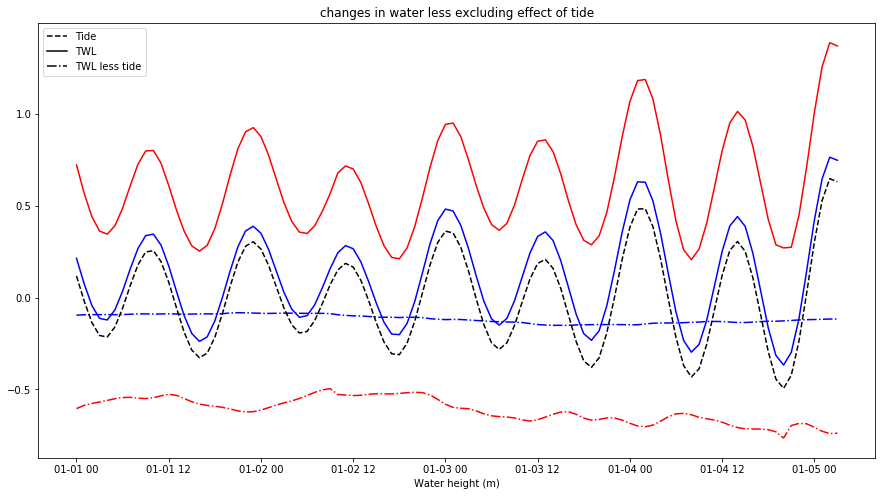

In [42]:
# For both Lagoon and Ocean, plot the tide, total water level, and the total water level less tide

# Format the axes
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot2grid((1,1),(0,0))

# Set the amount of data to plot 
plot_count = 100

# Plot the data
ax1.plot(df_Pto_lagoon.Time[:plot_count],df_Pto_lagoon.TWL_point_110[:plot_count],c='b',ls='-')
ax1.plot(df_Pto_lagoon.Time[:plot_count],df_Pto_lagoon.TWL_point_110_less_Tide[:plot_count],c='b',ls='-.')

ax1.plot(df_Pto_ocean.Time[:plot_count],df_Pto_ocean.TWL_point_218[:plot_count],c='r',ls='-')
ax1.plot(df_Pto_ocean.Time[:plot_count],df_Pto_ocean.TWL_point_218_less_Tide[:plot_count],c='r',ls='-.')

# Tide comes from the same datasource, plot as black
ax1.plot(df_Pto_lagoon.Time[:plot_count],df_Pto_lagoon.Tide[:plot_count],c='k',ls='--')

# Create a legend
l1 = plt.Line2D([],[],c='k',ls='--')
l2 = plt.Line2D([],[],c='k',ls='-')
l3 = plt.Line2D([],[],c='k',ls='-.')
ax1.legend([l1,l2,l3],['Tide','TWL','TWL less tide'])

# Format axes
ax1.set_xlabel('Time (hours)')
ax1.set_xlabel('Water height (m)')
ax1.set_title('changes in water less excluding effect of tide')

print('')

Much more variability on the ocean side (not surprising). Have a look at how much could be accounted for by wave height at that some point

## Removing effect of tide on ocean side total water level

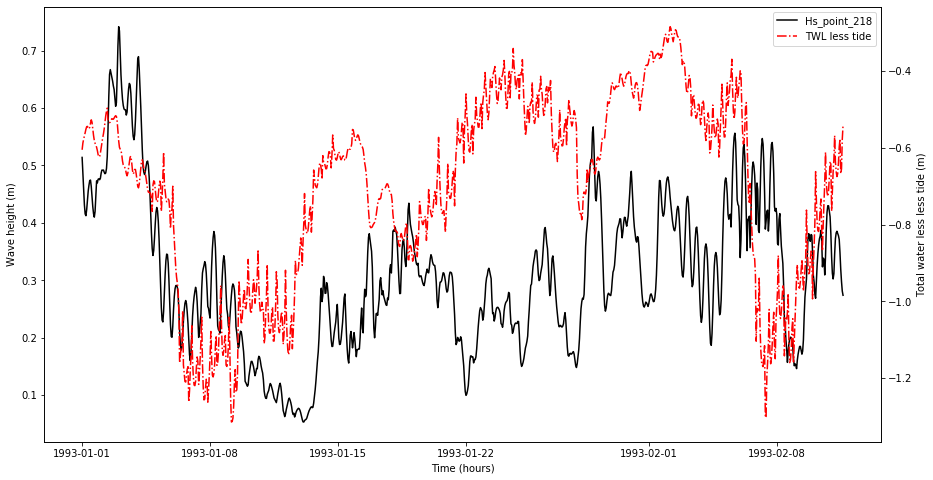

In [43]:
## Plot wave height vs total water level of ocean side (piont 218)

# Set up the figure
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot2grid((1,1),(0,0))
ax1t = ax1.twinx()

# Ocean side, plot the wave height and the total water level less tide
ax1.plot(df_Pto_ocean.Time[:plot_count*10],df_Pto_ocean.Hs_point_218[:plot_count*10],c='k',ls='-')
ax1t.plot(df_Pto_ocean.Time[:plot_count*10],df_Pto_ocean.TWL_point_218_less_Tide[:plot_count*10],c='r',ls='-.')

# Create a legend
l1 = plt.Line2D([],[],c='k',ls='-')
l2 = plt.Line2D([],[],c='r',ls='-.')
ax1.legend([l1,l2],['Hs_point_218','TWL less tide'])

# Format axes
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Wave height (m)')
ax1t.set_ylabel('Total water less less tide (m)')

print('')

# Generating Bayesian Network using SMILE engine

## Ocean side BN

### Preprocessing

In [44]:
# # Preprocess the data and save as a new csv that can be read by pysmile
# Create the network without considering time
df_Pto_ocean = df_Pto_ocean[all_vars_ocean]

# Drop the variable that I created called that removed tide
df_Pto_ocean = df_Pto_ocean.drop('TWL_point_218_less_Tide',axis=1)

# Discretise the data using kmeans clustering
# Set up discretising function
est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')

# Turn dataframe into array for the discretiser
pto_ocean_array = np.array(df_Pto_ocean[list(df_Pto_ocean)])

# Use the discretiser on the array and gen output
est.fit(pto_ocean_array)
pto_ocean_disc_array = est.transform(pto_ocean_array)

# Turn the resulting discretised array back to a dataframe
df_pto_ocean_disc = pd.DataFrame(pto_ocean_disc_array).astype(str)

# Relabel the columns of the new dataframe
df_pto_ocean_disc.columns = list(df_Pto_ocean)
    
# Save back as csv
df_pto_ocean_disc.to_csv(r'C:\Users\shannonb\Documents\Model_and_data\Dataset\D2_SPC_inundation_model\Pto_218_oceanside_preprocessed.csv',index=False)


In [45]:
# # Preprocess the data and save as a new csv that can be read by pysmile
# Create the network without considering time
df_Pto_lagoon = df_Pto_lagoon[all_vars_lagoon]

# Drop the variable that I created called that removed tide
df_Pto_lagoon = df_Pto_lagoon.drop('TWL_point_110_less_Tide',axis=1)

# Discretise the data using kmeans clustering
# Set up discretising function
est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')

# Turn dataframe into array for the discretiser
pto_lagoon_array = np.array(df_Pto_lagoon[list(df_Pto_lagoon)])

# Use the discretiser on the array and gen output
est.fit(pto_lagoon_array)
pto_lagoon_disc_array = est.transform(pto_lagoon_array)

# Turn the resulting discretised array back to a dataframe
df_pto_lagoon_disc = pd.DataFrame(pto_lagoon_disc_array).astype(str)

# Relabel the columns of the new dataframe
df_pto_lagoon_disc.columns = list(df_Pto_lagoon)
    
# Save back as csv
df_pto_lagoon_disc.to_csv('../Data_files/Pto_218_lagoonside_preprocessed.csv',index=False)


FileNotFoundError: [Errno 2] No such file or directory: '../Data_files/Pto_218_lagoonside_preprocessed.csv'

### Learning BN from Data

In [ ]:
# Structure Learning using pysmile
ds_ocean = pysmile.learning.DataSet()
ds_ocean.read_file('../Data_files/Pto_218_oceanside_preprocessed.csv')

# Use Bayesian Search algorithm to learn the network from the data
bay_search = pysmile.learning.BayesianSearch()
net_ocean = bay_search.learn(ds_ocean)

# Plot the learned graph
graph_learned_ocean = BN_visualisation(ds_ocean,df_Pto_ocean,net_ocean).graph
print('Ocean Side:')
graph_learned_ocean

In [ ]:
# Structure Learning using pysmile
ds_lagoon = pysmile.learning.DataSet()
ds_lagoon.read_file('../Data_files/Pto_218_lagoonside_preprocessed.csv')

# Use Bayesian Search algorithm to learn the network from the data
bay_search = pysmile.learning.BayesianSearch()
net_lagoon = bay_search.learn(ds_lagoon)

# Plot the learned graph
graph_learned_lagoon = BN_visualisation(ds_lagoon,df_Pto_lagoon,net_lagoon).graph
print('Lagoon side:')
graph_learned_lagoon

The learned networks don't seem to make any sense to me. Try creating the networks from scratch

### Building BN arcs from scratch

According to Antonio's presentation:
- TWL = Wave_SU+Wind_SU.

Using details from presentation, Goda (1985) and Feij et al. (2014), come up with arcs for BN

I'm not sure why there is no Tm_point_110

In [ ]:
# create a network from the old network (so that I don't have to make nodes again..)
net_ocean_manual = net_ocean

# Get all the node ids
all_nodes_ocean = net_ocean_manual.get_all_nodes()

# Loop over every combination of the nodes and, if there is an arc, remove it
for node1,node2 in itertools.product(all_nodes_ocean,all_nodes_ocean):
    try:
        net_ocean_manual.delete_arc(node1,node2)
    except:
        continue

# Add the arcs that I think should exist
net_ocean_manual.add_arc(0,4) # Tide -> TWL_point_218
net_ocean_manual.add_arc(1,4) # MSL -> TWL_point_218
net_ocean_manual.add_arc(2,4) # Hs_point_218 -> TWL_point_218
net_ocean_manual.add_arc(3,4) # Tm_point_218 -> TWL_point_218

# Plot the graph
graph_ocean_manual = BN_visualisation(ds_ocean,df_Pto_ocean,net_ocean_manual).graph
print('Ocean side:')
graph_ocean_manual

In [ ]:
# create a network from the old network (so that I don't have to make nodes again..)
net_lagoon_manual = net_lagoon

# Get all the node ids
all_nodes_lagoon = net_lagoon_manual.get_all_nodes()

# Loop over every combination of the nodes and, if there is an arc, remove it
for node1,node2 in itertools.product(all_nodes_lagoon,all_nodes_lagoon):
    try:
        net_lagoon_manual.delete_arc(node1,node2)
    except:
        continue
        
lagoon_node_ids = {}

for node, node_id in zip(net_lagoon_manual.get_all_node_ids(), all_nodes_lagoon):
    lagoon_node_ids.update({
        node:node_id
    })


# Add the arcs that I think should exist
net_lagoon_manual.add_arc(lagoon_node_ids['Tide'],lagoon_node_ids['TWL_point_110']) 
net_lagoon_manual.add_arc(lagoon_node_ids['MSL'],lagoon_node_ids['TWL_point_110'])
net_lagoon_manual.add_arc(lagoon_node_ids['Hs_point_110'],lagoon_node_ids['TWL_point_110'])
net_lagoon_manual.add_arc(lagoon_node_ids['Tm_offshore'],lagoon_node_ids['Hs_point_110'])
net_lagoon_manual.add_arc(lagoon_node_ids['Hs_offshore'],lagoon_node_ids['Hs_point_110'])
net_lagoon_manual.add_arc(lagoon_node_ids['Wind'],lagoon_node_ids['Hs_offshore'])
net_lagoon_manual.add_arc(lagoon_node_ids['Wind'],lagoon_node_ids['Tm_offshore'])
net_lagoon_manual.add_arc(lagoon_node_ids['Dir_offshore'],lagoon_node_ids['Hs_point_110'])
net_lagoon_manual.add_arc(lagoon_node_ids['WindDir'],lagoon_node_ids['Hs_offshore'])
net_lagoon_manual.add_arc(lagoon_node_ids['WindDir'],lagoon_node_ids['Tm_offshore'])
net_lagoon_manual.add_arc(lagoon_node_ids['Wind'],lagoon_node_ids['Dir_offshore'])
net_lagoon_manual.add_arc(lagoon_node_ids['WindDir'],lagoon_node_ids['Dir_offshore'])

# Plot the graph  
graph_lagoon_manual = BN_visualisation(ds_lagoon,df_Pto_lagoon,net_lagoon_manual).graph
print('Lagoon Side:')
graph_lagoon_manual

### Learn Parameters and Validate the Network from Data

Using the networks that I created, use expectation maximisation to estimate the parameters of the network. Validate the results using k-fold (5 folds) crossvalidation on the total water level.

What exactly is the 'accuracy' metric that is generated by SMILE? How is it calculated?

In [ ]:
## For ocean side
# Setup  the validator
matching_ocean = ds_ocean.match_network(net_ocean)
validator_ocean = pysmile.learning.Validator(net_ocean, ds_ocean, matching_ocean)

# Validate the results on the total water level node 
classNodeHandle_ocean = net_ocean.get_node("TWL_point_218")

# Add total water level node to the validator
validator_ocean.add_class_node(classNodeHandle_ocean)

# Get the expectation maximisation (EM) function for parameter estimation
em = pysmile.learning.EM()

# Using expectation-maximisation, determine the accuracy using k_fold (5) cross validation
validator_ocean.k_fold(em, 5)
acc_ocean = validator_ocean.get_accuracy(classNodeHandle_ocean, 0)

print("Accuracy for predicting TWL, ocean side: ",acc_ocean)

# Learn the paramters using EM
em.learn(data=ds_ocean, net=net_ocean, matching=matching_ocean)

# Save the network
net_ocean.write_file("../BN_model_files/Pto_218_oceanside_learned_network.xdsl")

In [ ]:
## For lagoon side
# Setup  the validator
matching_lagoon = ds_lagoon.match_network(net_lagoon)
validator_lagoon = pysmile.learning.Validator(net_lagoon, ds_lagoon, matching_lagoon)

# Validate the results on the total water level node 
classNodeHandle_lagoon = net_lagoon.get_node("TWL_point_110")

# Add total water level node to the validator
validator_lagoon.add_class_node(classNodeHandle_lagoon)

# Get the expectation maximisation (EM) function for parameter estimation
em = pysmile.learning.EM()

# Using expectation-maximisation, determine the accuracy using k_fold (5) cross validation
validator_lagoon.k_fold(em, 5)
acc_lagoon = validator_lagoon.get_accuracy(classNodeHandle_lagoon, 0)

print("Accuracy for predicting TWL, lagoon side: ",acc_lagoon)

# Learn the paramters using EM
em.learn(data=ds_lagoon, net=net_lagoon, matching=matching_lagoon)

# Save the network
net_lagoon.write_file("../BN_model_files/Pto_218_lagoonside_learned_network.xdsl")

### Test Set Evidence

In [ ]:
print('MSL id:',net_lagoon.get_node('MSL'))
print('TWL_point_110 id:',net_lagoon.get_node('TWL_point_110'))

net_lagoon.clear_all_evidence()
net_lagoon.set_virtual_evidence(2,[0,1,0,0])
print(net_lagoon.get_virtual_evidence(2))
net_lagoon.update_beliefs()

print(net_lagoon.get_node_value(8))


In [ ]:
print('Tide id:',net_lagoon.get_node('Tide'))
print('TWL_point_110 id:',net_lagoon.get_node('TWL_point_110'))

net_lagoon.clear_all_evidence()
net_lagoon.set_virtual_evidence(5,[0,0,1,0])
# print(net_lagoon.get_virtual_evidence(2))
net_lagoon.update_beliefs()

print(net_lagoon.get_node_value(8))


# Comparing to BEWARE Database

## Import BEWARE Database

In [ ]:
## Import the Beware data
ds_beware = xr.open_dataset('../Data_files/BEWARE_Database.nc')

In [ ]:
## Input parameters
array_H0_beware = np.array(ds_beware['H0']) # offshore significant wave height
array_eta0_beware = np.array(ds_beware['eta0']) # offshore water level
array_H0L0_beware = np.array(ds_beware['H0L0']) # offshore wave steepness (l0 offshore wave length)
array_beta_ForeReef_beware = np.array(ds_beware['beta_ForeReef']) # Fore reef slope
array_beta_Beach_beware = np.array(ds_beware['beta_Beach']) # Beach slope
array_Cf_beware = np.array(ds_beware['Cf']) # Coefficient of friction
array_W_reef_beware = np.array(ds_beware['W_reef']) # Width of reef flat

## Output parameters
array_Hm0_SS_beware = np.array(ds_beware['Hm0_SS']) # Significant sea/swell wave height
array_Hm0_IG_beware = np.array(ds_beware['Hm0_IG']) # Significant infragravity wave height
array_Hm0_VLF_beware = np.array(ds_beware['Hm0_VLF']) # Significant very low frequency wave height 
array_Hm0_LF_beware = np.array(ds_beware['Hm0_LF']) # Significant low frequency wave height 
array_Tm1_0_beware = np.array(ds_beware['Tm1_0']) # Mean spectral period
array_R2pIndex_beware = np.array(ds_beware['R2pIndex']) # Runup (2% exceedance value) on beach slope

## Variables that I don't know what they do yet
# etaMean_innerReefFlat
# etaMean_meanReefFlat
# Hm0
# etaComponents
# runupComponents

# Discretising the Data